# ElectroStatic Solver 1

This notebook shows the obtention of electrostatic forces on a boundary due to the application of a high voltage.

It exports the values of the electric field and finds the electrostatic forces on each node in the boundary outside of FeniCs. It returns a List of points and a list of Forces, assigned to each point.

In [ ]:
#Setup FeniCs, must run in Colab

!wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
import dolfin
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

In [3]:
pip install meshio #Install meshio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import meshio
#Use this lines if you wish import your mesh as a msh (GMSH) file
msh2 = meshio.read("NSlev.msh")
meshio.write("NSlev.xml",msh2)
mesh = Mesh("NSlev.xml")

Text(0, 0.5, 'Voltage applied [V]')

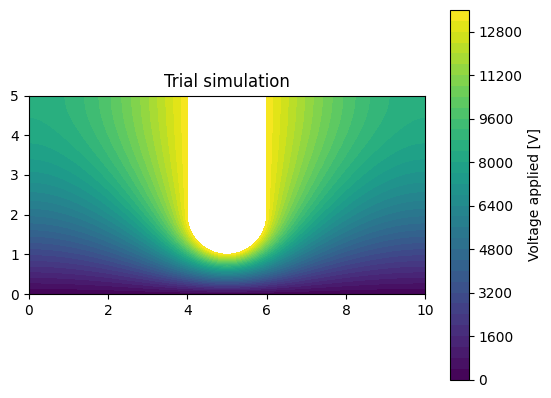

In [23]:
 #Solves Poisson Equation in order to get electric potential at every point
from dolfin import *
import meshio
#Define parameters for simplicity
#This block of code provides a general mesh case, it can be modified in accordance to the problem needed

originx = 0
originy = 0
origin = Point(originx,originy)

bigRectx = 10
bigRecty = 5
bigRect = Point(bigRectx, bigRecty)

rect2_1x = 4
rect2_1y = 2
rect2_1 = Point(rect2_1x,rect2_1y)

rect2_2x = 6
rect2_2y = 5
rect2_2 = Point(rect2_2x,rect2_2y)


rect1 = Rectangle(origin, bigRect)
rect2 = Rectangle(rect2_1, rect2_2)
circle = Circle(Point(5 , 2), 1 )

domain = rect1 - rect2 - circle
mesh = generate_mesh(domain, 250)


"""msh = meshio.read("NSlev.xml")
mesh = Mesh("NSlev.xml")"""

V = FunctionSpace(mesh, 'CG', 1)

v_0 = Constant(0) #Defines ground
v_2 = Constant(13500) #Voltage that is applied to the needle

def bottom_side(x, on_boundary): #Defines the boundary for the collector
    if (near(x[1], 0) )  and on_boundary:
        return True

def voltage(x,on_boundary): #Defines the boudary on which there is a voltage is applied. Aka, the needle
  Bool = False
  if on_boundary:
    if ((near(x[1],0) or near(x[0],0) or near(x[0],10) or near(x[1],5))): #Change these values for the boundaries of the mesh used.
      return Bool
    else:
      return True

bot_bc = DirichletBC(V, v_0, bottom_side)
drop_bc = DirichletBC(V, v_2, voltage)
bcs = [bot_bc, drop_bc] #Creates Dirichlet conditions for the electrostatic potential

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
a = dot(grad(u), grad(v))*dx #Define variational form for Poissons equation
L = f*v*dx #Define variational form

u = Function(V)
solve(a == L, u, bcs) #Solve linear system for the potential (u)

a  = plot(u , title = "Trial simulation") #Plot solution (if needed)
cbar = plt.colorbar(a)
cbar.ax.set_ylabel('Voltage applied [V]')


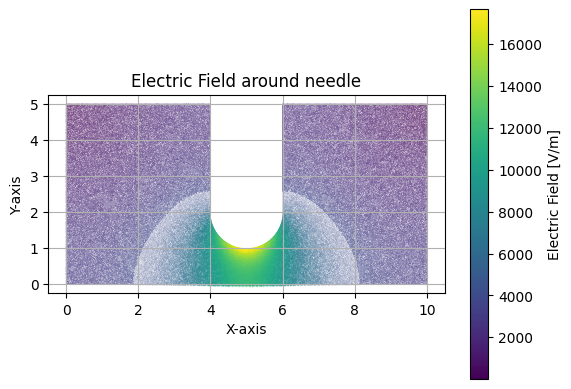

In [24]:
import numpy as np

#Define E in terms of the gradient of the electric potential

E = project(-grad(u), VectorFunctionSpace(mesh, 'CG', 1)) #Projection, in order to get to obtain E (vectorfield)
EX, EY = E.split(deepcopy=True)  # extract components

b = plot(E, title="Electric Field around needle") #Plot E
cbar = plt.colorbar(b)
cbar.ax.set_ylabel('Electric Field [V/m]')

# Add grid and axis number lines
plt.grid(True)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')


file = File("Eiter1.pvd") #Save the value of E for visualization in Paraview
file << E


In [25]:

# Get the nodal values as a NumPy array
E_array = EX.vector().get_local()

# Get the coordinates of the nodes
mesh_coordinates = mesh.coordinates()


In [26]:
#Block of code used to extract the values for the nodes at the boundary
class boundary(SubDomain):
    def inside(self, x, on_boundary): #Define a subdomain of the mesh, only with the nodes where the following conditions are met
      if on_boundary:
        if near(x[0], 0) or near(x[0], 10) or near(x[1],0) or near(x[1],5) or near(x[0], 0.4) or near(x[0], 0.6): #Change according to the boundaries for your problem
          return False
        else:
          return True
      else:
        return False


V = FunctionSpace(mesh, "CG", 1)
mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary().mark(mf, 1) #Mark the elements of the desired boundary
v2d = vertex_to_dof_map(V)
dofs = []

for facet in facets(mesh): #Obtain a list of the marked nodes
    if mf[facet.index()] == 1:
        vertices = facet.entities(0)
        for vertex in vertices:
            dofs.append(v2d[vertex])

unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
boundary_coords = V.tabulate_dof_coordinates()[unique_dofs]

np.sort(boundary_coords)
for i, dof in enumerate(unique_dofs):
    #print(boundary_coords[i])
    a=0

def sort_coordinates(coordinates, start_node): #Sorts the coordinates due to a point, due to the angle between a point and the centroid (the centroid of the needle works fine)
    # Find the centroid as the reference point
    centroid = np.mean(coordinates, axis=0)

    # Calculate the angles with respect to the centroid
    angles = np.arctan2(coordinates[:, 1] - centroid[1], coordinates[:, 0] - centroid[0])

    # Calculate angles with respect to the start node
    start_angle = np.arctan2(start_node[1] - centroid[1], start_node[0] - centroid[0])
    angles_relative = (angles - start_angle + 2 * np.pi) % (2 * np.pi)

    # Sort the coordinates based on angles
    sorted_indices = np.argsort(angles_relative)
    sorted_coordinates = coordinates[sorted_indices]

    return sorted_coordinates

sorted_coordinates = sort_coordinates(boundary_coords,[5,5])

#This functions extracts the value of the E field at a point given.
def exctractE (coordinates):
  E = []
  for i in range(0, len(coordinates)):
    Ex = EX(Point(coordinates[i][0], coordinates[i][1]))
    Ey = EY(Point(coordinates[i][0], coordinates[i][1]))
    E.append([Ex,Ey])

  return E

Ele = exctractE(sorted_coordinates)

array1_tuples = [tuple(item) for item in sorted_coordinates]
dictE = dict(zip(array1_tuples, Ele))


In [27]:

#Given Two Points, this function gives a unit normal vector to the line created by the two points
def normal_unit_vector(point1, point2):
    # Calculate the direction vector of the line
    direction_vector = np.array(point2) - np.array(point1)

    # Calculate the normal vector
    normal_vector = np.array([-direction_vector[1], direction_vector[0]])

    # Normalize the normal vector to get the unit normal vector
    unit_normal_vector = (normal_vector / np.linalg.norm(normal_vector))
    b = np.array(unit_normal_vector).tolist()
    b = [-1*b[0] , -1*b[1]]
    return b

#Averages the value of the Electric Field (The average value of E in the two nodes that create the line)
def average_of_vectors(vectors):
    result = []

    for i in range(1, len(vectors)):
        avg_vector = [(vectors[i-1][0] + vectors[i][0]) / 2, (vectors[i-1][1] + vectors[i][1]) / 2]
        result.append(avg_vector)

    return result

avgE = average_of_vectors(Ele)

#Get normal vectors to every set of points

normalVectors = []
for i in range(0, len(array1_tuples)-1):
  n = normal_unit_vector(array1_tuples[i], array1_tuples[i+1])
  normalVectors.append(n)




In [28]:
#Calculate electrostatic Force, using maxwell stress tension definition

epsilon = 8.85E-12

u = []
for i in range (0,len(normalVectors)):
  ui = avgE[i][0]* normalVectors[i][0] + avgE[i][1]* normalVectors[i][1]
  u.append(ui)

T1 = []
for i in range (0,len(normalVectors)):
  T1X = u[i]*avgE[i][0]
  T1Y = u[i]*avgE[i][1]
  T1.append([T1X,T1Y])

v = []
for i in range(0,len(normalVectors)):
  vi = -0.5*( avgE[i][0]**2 + avgE[i][1]**2)
  v.append(vi)

T2 = []
for i in range(0,len(normalVectors)):
  T2X = v[i]*normalVectors[i][0]
  T2Y = v[i]*normalVectors[i][1]
  T2.append([T2X,T2Y])

F = []
for i in range(0,len(normalVectors)):
  FX = epsilon*(T1[i][0] + T2[i][0])
  FY = epsilon*(T1[i][1] + T2[i][1])
  F.append([FX,FY])


<ipython-input-29-b589df43633d>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', label='Force Magnitude [N]')


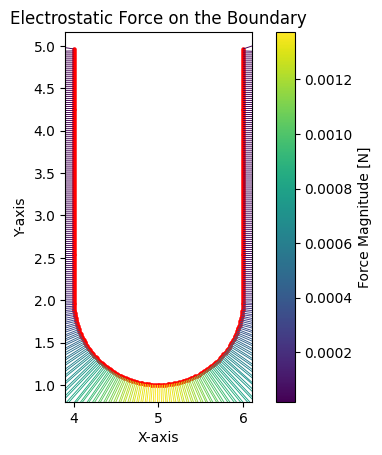

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm
#Function used to visualize the vectors annd the points
def plot_points_and_vectors(points, vectors):
    fig, ax = plt.subplots()

    # Normalize vectors to make them unitary
    norms = np.linalg.norm(vectors, axis=1)
    unit_vectors = vectors / norms[:, np.newaxis]

    # Use a color map to represent vector magnitudes
    magnitudes = np.linalg.norm(vectors, axis=1)
    norm = Normalize(vmin=min(magnitudes), vmax=max(magnitudes))
    colors = cm.viridis(norm(magnitudes))

    # Define your custom scaling factor
    custom_scaling_factor = 10 #Length of the vectors

    # Plot points
    ax.scatter(*zip(*points), color='red', s=5)

    for i, point in enumerate(points):
      vector = custom_scaling_factor * unit_vectors[i]  # Adjust the length
      color = cm.viridis(norm(magnitudes[i]))

      scale = 0.001
      line_width = 0.005  # Set your desired line width here

      ax.quiver(point[0], point[1], vector[0], vector[1], angles='xy', scale_units='xy', scale=1,
                color=color, width=line_width, edgecolor=color)

    ax.set_aspect('equal')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Electrostatic Force on the Boundary')

    # Resize the grid
    plt.grid(True, linewidth=0.05, alpha=0.005)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', label='Force Magnitude [N]')

    plt.show()

def average_of_vectors(vectors):
    result = []

    for i in range(1, len(vectors)):
        avg_vector = [(vectors[i-1][0] + vectors[i][0]) / 2, (vectors[i-1][1] + vectors[i][1]) / 2]
        result.append(avg_vector)

    return result

# Example usage:
points = average_of_vectors(sorted_coordinates)

plot_points_and_vectors(points, F)


In [31]:
def calculate_magnitudes(vectors): #Calculate the magnitude of the electrostatic forces
    # Convert the list of vectors to a NumPy array
    vectors_array = np.array(vectors)

    # Calculate the magnitude of each vector
    magnitudes = np.linalg.norm(vectors_array, axis=1)

    return magnitudes

Fm = calculate_magnitudes(F)

In [32]:
import copy

newpoints = copy.deepcopy(points)
if (len(sorted_coordinates) != len(points)): #If an extra node exists, considering the value of F is close to cero on the Boundary, add an auxiliary node
  newpoints.append(points[-1])

len(newpoints)

411

In [33]:
"""
In order to correclty interpolate back the value of F into the nodes on the mesh, the nodes are extracted once again
"""

def newPotentialMesh(mesh2, dist, numedges):

  class boundary(SubDomain):
      def inside(self, x, on_boundary):
        if on_boundary:
          if near(x[0], 0) or near(x[0], 10) or near(x[1],0) or near(x[1],5) or near(x[0], 0.4) or near(x[0], 0.6):
            return False
          else:
            return True
        else:
          return False

  V = FunctionSpace(mesh2, "CG", 1)
  v = project(Expression("x[0]+x[1]", degree=1),V)
  mf = MeshFunction("size_t", mesh2, mesh2.topology().dim()-1, 0)
  boundary().mark(mf, 1)
  v2d = vertex_to_dof_map(V)
  dofs = []
  for facet in facets(mesh2):
      if mf[facet.index()] == 1:
          vertices = facet.entities(0)
          for vertex in vertices:
              dofs.append(v2d[vertex])

  unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
  boundary_coords1 = V.tabulate_dof_coordinates()[unique_dofs]
  return boundary_coords1

a = newPotentialMesh(mesh, 0,0)

nodes = sort_coordinates(a, [5,5])



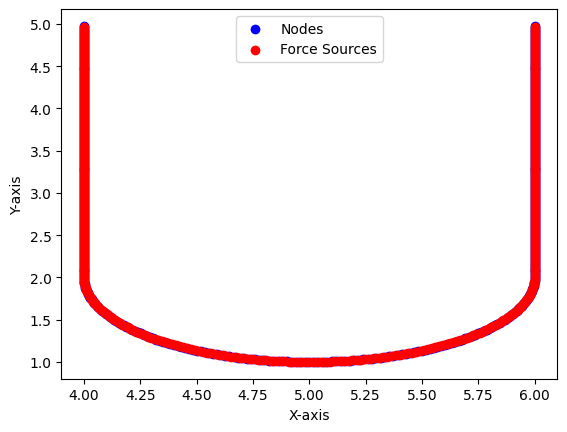

In [34]:
#Plot the points in which a a force is defined, and the points where a node is defined.
# Convert arrays to NumPy arrays for easy plotting
array1 = np.array(nodes)
array2 = np.array(points)

# Plot array1 in blue and array2 in red
plt.scatter(array1[:, 0], array1[:, 1], color='blue', label='Nodes')
plt.scatter(array2[:, 0], array2[:, 1], color='red', label='Force Sources')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()







<ipython-input-29-b589df43633d>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', label='Force Magnitude [N]')


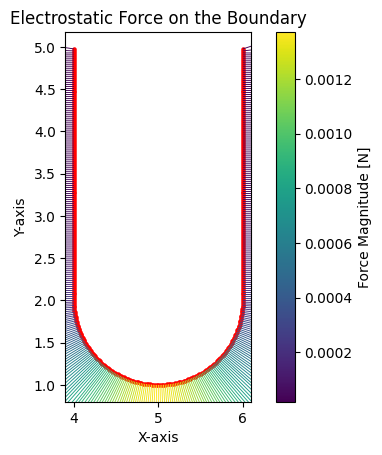

In [35]:
#Ponderate the values of the forces, in order to obtain the value of F on every node

interForces = []
interForces.append(F[0])

for i in range(0, len(points)-1):
  pointF1 = points[i]
  pointF2 = points[i+1]
  currnode = nodes[i+1]

  xprev = abs(pointF1[0] - currnode[0])
  yprev = abs(pointF1[1] - currnode[1])
  xnext = abs(pointF2[0] - currnode[0])
  ynext = abs(pointF2[1] - currnode[1])

  Fprev = F[i]
  Fnext = F[i+1]
  if(xnext+xprev == 0):
      Fx =  Fprev[0] + Fnext[0]/ 2
      Fy = ynext/(ynext+yprev) * Fprev[1] + yprev/(ynext+yprev) *Fnext[1]
  elif(ynext+yprev == 0):
      Fx = xnext/(xnext+xprev) * Fprev[0] + xprev/(xnext+xprev) *Fnext[0]
      Fy =  Fprev[1] + Fnext[1]/ 2

  else:
      Fx = xnext/(xnext+xprev) * Fprev[0] + xprev/(xnext+xprev) *Fnext[0]
      Fy = ynext/(ynext+yprev) * Fprev[1] + yprev/(ynext+yprev) *Fnext[1]

  interForces.append([Fx,Fy])

interForces.append(F[-1])

plot_points_and_vectors(nodes, interForces)



